In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download the DLIB Dataset

In [ ]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

## Visualize the dataset

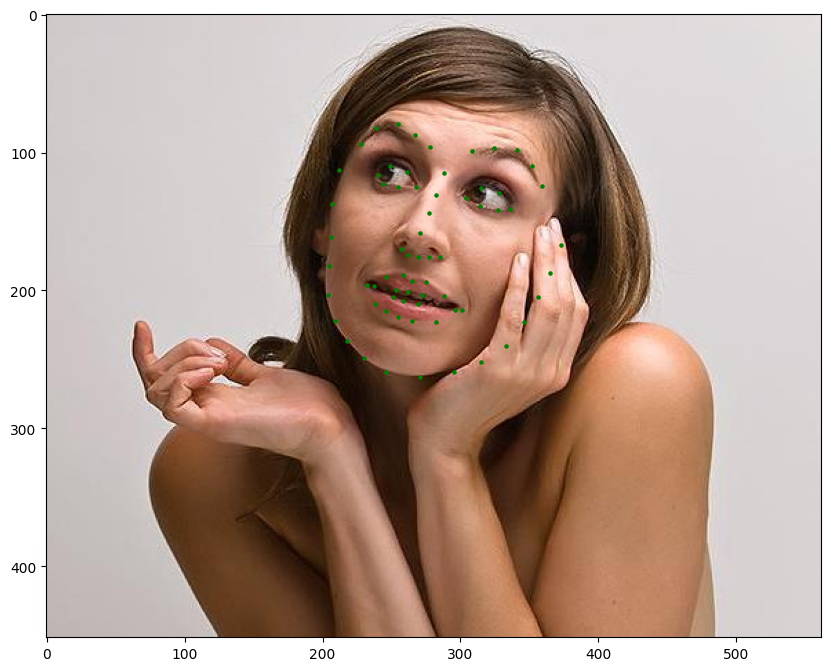

In [ ]:
file = open('/content/ibug_300W_large_face_landmark_dataset/helen/trainset/1004467229_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('/content/ibug_300W_large_face_landmark_dataset/helen/trainset/1004467229_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

## Create dataset class

In [ ]:
class Transforms():
    def __init__(self):
        pass

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
      left = int(crops['left'])
      top = int(crops['top'])
      width = int(crops['width'])
      height = int(crops['height'])

      image = TF.crop(image, top, left, height, width)

      if landmarks is not None and len(landmarks) > 0:
          img_shape = np.array(image).shape
          landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
          landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])

      return image, landmarks


    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        # image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        # Calculate interocular distance
        self.interocular_distances = []
        for landmark in self.landmarks:
            left_eye = landmark[36]  # Assuming landmarks are in iBUG annotation format
            right_eye = landmark[45]
            interocular_distance = np.linalg.norm(np.array(right_eye) - np.array(left_eye))
            self.interocular_distances.append(interocular_distance)


        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        interocular_distance = self.interocular_distances[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks, interocular_distance

dataset = FaceLandmarksDataset(Transforms())

## Visualize Train Transforms

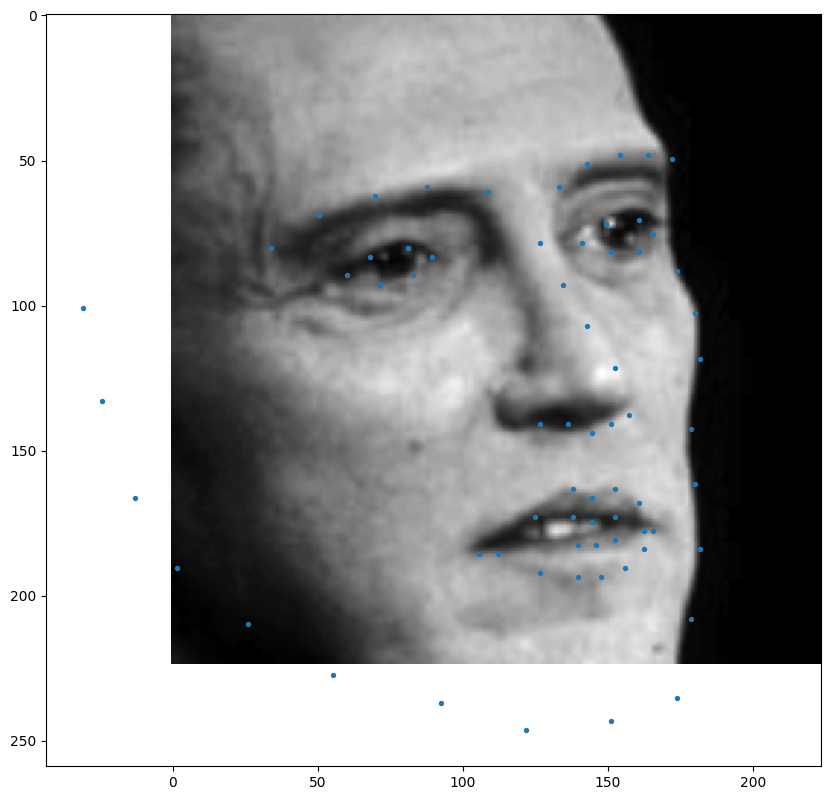

In [ ]:
image, landmarks, interocular_distance = dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

## Split the dataset into train and valid dataset

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset, = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=True, num_workers=2)

The length of Train set is 6000
The length of Valid set is 666


### Testing the shape of input data

In [ ]:
images, landmarks, interocular_distance = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([512, 1, 224, 224])
torch.Size([512, 68, 2])


## Define the model

In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

## Helper Functions

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [ ]:
import torch
import numpy as np

def calculate_nme(predictions, targets, interocular_distance):
    euclidean_distances = np.linalg.norm(predictions - targets, axis=-1)
    normalized_distances = euclidean_distances / interocular_distance
    mean_nme = np.mean(np.float64(normalized_distances))
    return mean_nme

## Train

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
# network.cuda()
network.to('cuda')

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

train_nme_values = []
valid_nme_values = []

start_time = time.time()

for epoch in range(1,num_epochs+1):

    loss_train = 0
    loss_valid = 0
    running_loss = 0

    network.train()
    train_loader_iter = iter(train_loader)
    valid_loader_iter = iter(valid_loader)

    epoch_train_nme_values = []


    for step in range(1, len(train_loader_iter) + 1):

        images, landmarks, interocular_distance = next(train_loader_iter)

        # images = images.cuda()
        images = images.to('cuda')
        # landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).to('cuda')

        predictions = network(images)

        nme_train_step = calculate_nme(predictions.detach().cpu().numpy(), landmarks.cpu().numpy(), interocular_distance)
        epoch_train_nme_values.append(nme_train_step)


        print_overwrite(step, len(train_loader), running_loss, 'train')
        print(f" NME: {nme_train_step:.4f}")
        # clear all the gradients before calculating them
        optimizer.zero_grad()

        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        print_overwrite(step, len(train_loader), running_loss, 'train')

    mean_nme_train_epoch = np.mean(epoch_train_nme_values)
    train_nme_values.append(mean_nme_train_epoch)
    print(train_nme_values)
    network.eval()
    with torch.no_grad():

        epoch_valid_nme_values = []
        for step, (images, landmarks, interocular_distance) in enumerate(train_loader, 1):


            # images = images.cuda()
            images = images.to('cuda')
            # landmarks = landmarks.view(landmarks.size(0),-1).cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).to('cuda')

            predictions = network(images)
            # calculate metrics
            nme_valid_step = calculate_nme(predictions.detach().cpu().numpy(), landmarks.cpu().numpy(), interocular_distance)
            epoch_valid_nme_values.append(nme_valid_step)


            # Print or log the metrics
            print_overwrite(step, len(valid_loader), running_loss, 'valid')
            print(f" NME: {nme_valid_step:.4f}")

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    mean_nme_valid_epoch = np.mean(epoch_valid_nme_values)
    valid_nme_values.append(mean_nme_valid_epoch)


    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/drive/MyDrive/CV/Model/face_landmarks.pth')
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Train Steps: 1/12  Loss: 0.0000  NME: 0.0413
Train Steps: 2/12  Loss: 0.3278  NME: 0.0361
Train Steps: 3/12  Loss: 0.2886  NME: 0.0328
Train Steps: 4/12  Loss: 0.2599  NME: 0.0292
Train Steps: 5/12  Loss: 0.2355  NME: 0.0261
Train Steps: 6/12  Loss: 0.2133  NME: 0.0242
Train Steps: 7/12  Loss: 0.1942  NME: 0.0208
Train Steps: 8/12  Loss: 0.1771  NME: 0.0173
Train Steps: 9/12  Loss: 0.1625  NME: 0.0170
Train Steps: 10/12  Loss: 0.1498  NME: 0.0146
Train Steps: 11/12  Loss: 0.1388  NME: 0.0138
Train Steps: 12/12  Loss: 0.1291  NME: 0.0120
Train Steps: 12/12  Loss: 0.1205 [0.023764149158012882]
Valid Steps: 1/3  Loss: 0.1205  NME: 0.0148
Valid Steps: 2/3  Loss: 0.0360  NME: 0.0134
Valid Steps: 3/3  Loss: 0.0364  NME: 0.0136
Valid Steps: 4/3  Loss: 0.0363  NME: 0.0140
Valid Steps: 5/3  Loss: 0.0363  NME: 0.0142
Valid Steps: 6/3  Loss: 0.0364  NME: 0.0138
Valid Steps: 7/3  Loss: 0.0363  NME: 0.0150
Valid Steps: 8/3  Loss: 0.0364  NME: 0.0142
Valid Steps: 9/3  Loss: 0.0364  NME: 0.0144
Valid

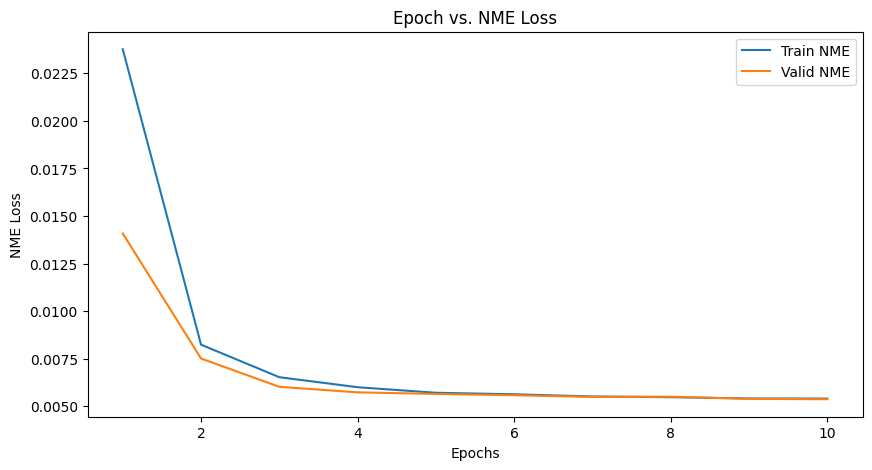

In [ ]:
import matplotlib.pyplot as plt
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_nme_values, label='Train NME')
plt.plot(epochs, valid_nme_values, label='Valid NME')
plt.xlabel('Epochs')
plt.ylabel('NME Loss')
plt.title('Epoch vs. NME Loss')
plt.legend()
plt.show()

In [ ]:
from scipy.spatial import distance
def plot_landmark_errors(predictions, ground_truth):
    errors = distance.cdist(predictions, ground_truth, 'euclidean')
    mean_errors = np.mean(errors, axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(mean_errors, marker='o')
    plt.title('Mean Euclidean Distance Errors for Facial Landmarks')
    plt.xlabel('Landmark Index')
    plt.ylabel('Mean Euclidean Distance Error')
    plt.show()

## Predict on Test Images

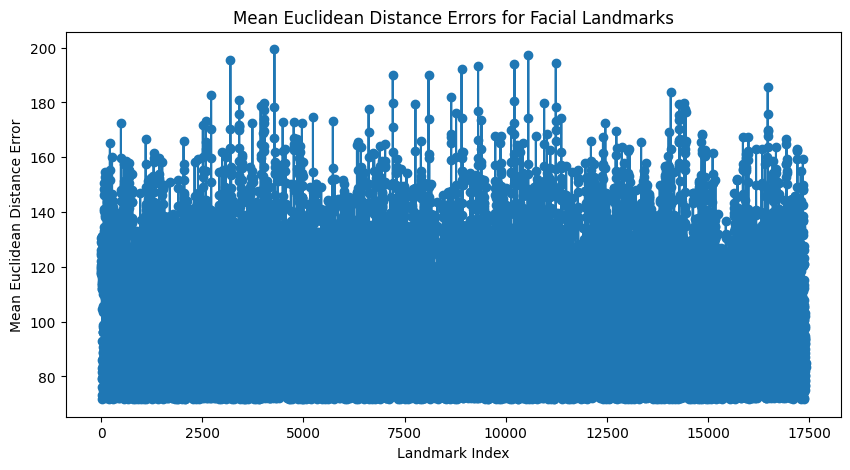

Total number of test images: 666
Elapsed Time : 16.09470558166504


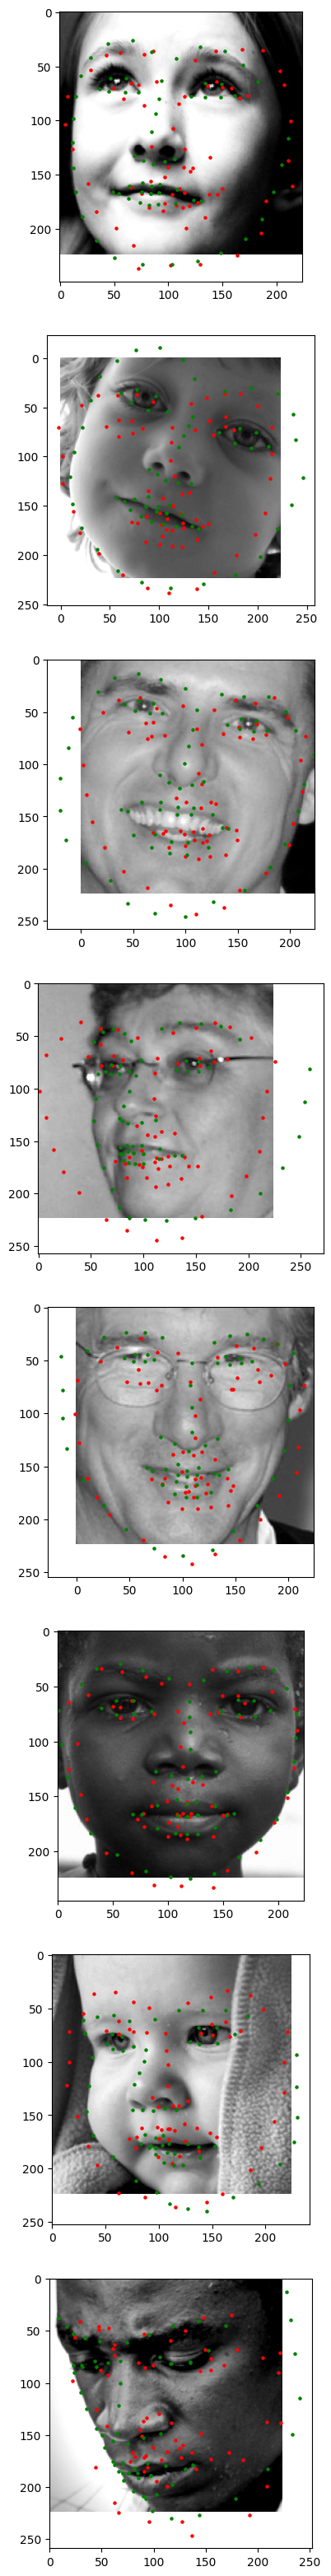

In [ ]:
start_time = time.time()

landmarks_data = []

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/drive/My Drive/CV/Model/face_landmarks.pth'))
    best_network.eval()

    images, landmarks, interocular_distance = next(iter(valid_loader))

    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)

    plot_landmark_errors(predictions.numpy().reshape(-1, 2), landmarks.numpy().reshape(-1, 2))

    plt.figure(figsize=(10,40))



    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

        # Collect predicted landmarks for saving
        landmarks_data.append(landmarks[img_num].numpy().flatten())

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time))

dat_file_path = '/content/drive/My Drive/CV/Model/predicted_landmarks.dat'
np.savetxt(dat_file_path, np.array(landmarks_data))

## Novel OpenCV Algorithm Implementation



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [ ]:
class Pixel:
  def __init__(self, file):
    self.img = cv2.imread(file)
    self.img = cv2.resize(self.img, (256, 256))
    self.mask = np.zeros(self.img.shape[:2], np.uint8)
    self.bgdModel = np.zeros((1,65), np.float64)
    self.fgdModel = np.zeros((1,65), np.float64)
    self.rect = (10, 10, 900, 600)
    cv2.grabCut(self.img, self.mask, self.rect, self.bgdModel, self.fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    self.mask2 = np.where((self.mask==2) | (self.mask==0), 0, 1).astype('uint8')
    self.img = self.img * self.mask2[:, :, np.newaxis]
    self.np_img = np.asarray(self.img)

  def return_img(self):
    return self.np_img

In [ ]:
static_address = 'drive/My Drive/CV/CV Implementation Images/Anger/'
extension = '.jpg'

file_list = []

for file in range(40):
  filename = static_address + str(file + 1) + extension
  file_list.append(filename)

In [ ]:
file_list

In [ ]:
# np_img1 = Pixel(file1).return_img()
# np_img2 = Pixel(file2).return_img()
np_list = []

for file in file_list:
  processed_file = Pixel(file).return_img()
  print(f"File Processed: {file}")
  np_list.append(processed_file)

File Processed: drive/My Drive/CV/CV Implementation Images/Anger/1.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/2.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/3.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/4.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/5.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/6.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/7.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/8.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/9.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/10.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/11.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/12.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/13.jpg
File Processed: drive/My Drive/CV/CV Implementation Images/Anger/14.jpg
F

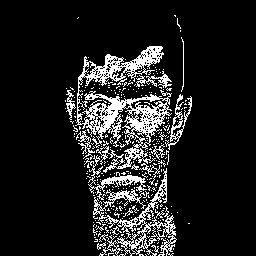

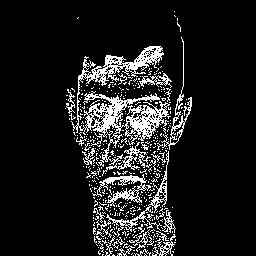

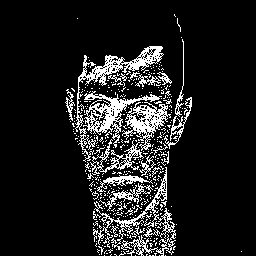

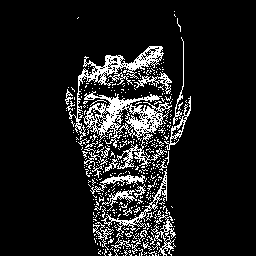

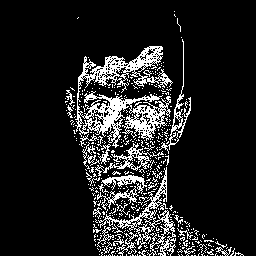

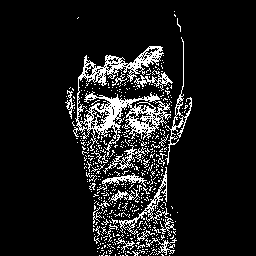

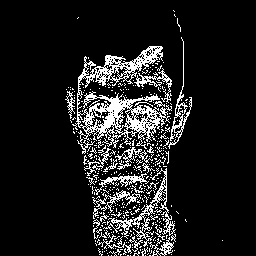

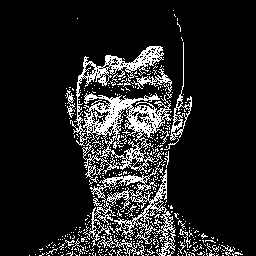

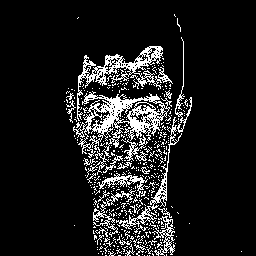

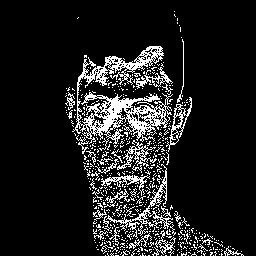

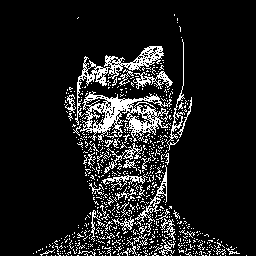

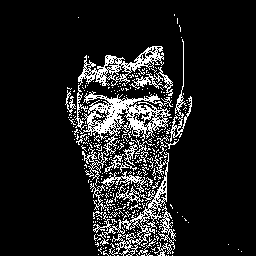

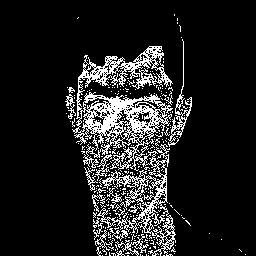

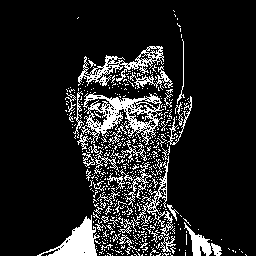

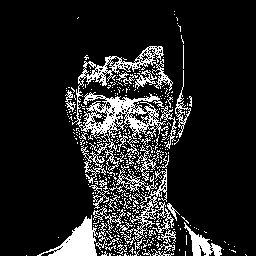

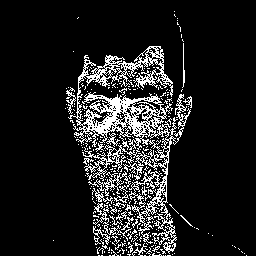

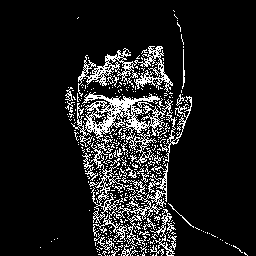

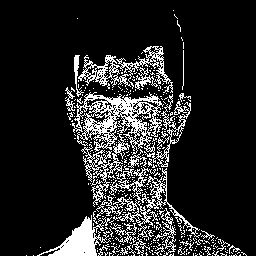

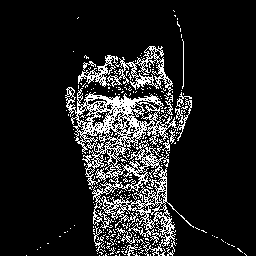

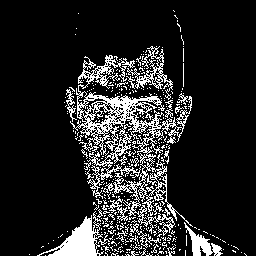

In [ ]:
for i in range(20):
  np_img1 = np_list[i]
  np_img2 = np_list[i + 20]
  # (np_img1 == np_img2).all() # For comparison of np arrays
  diff1 = np.subtract(np_img2, np_img1)
  diff1 = np.where(diff1 < 230, 0, 255)
  data = Image.fromarray((diff1 * 1).astype(np.uint8)).convert('RGB')
  display(data)

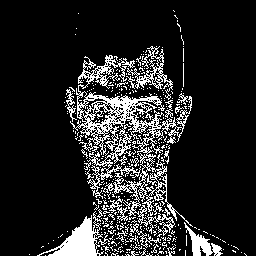

In [ ]:
diff1 = np.subtract(np_img2, np_img1)
diff1
# diff2 = np.subtract(np_img32, np_img2)

# data = Image.fromarray((diff * 1).astype(np.uint8)).convert('RGB')
# display(data)

# diff.shape

diff1 = np.where(diff1 < 230, 0, 255)
diff1
# diff2 = np.where(diff2 > 0, 255, diff2)

# final_diff = np.subtract(diff2, diff1)

data = Image.fromarray((diff1 * 1).astype(np.uint8)).convert('RGB')
display(data)

In [ ]:
np.where(diff1 < 255)
diff1[255]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [  0,   0,   0],
       [  0,   0